# Лабораторная работа 1: «Метод обратного распространения ошибки»


Демонстрация избранных изображений и меток классов для подтверждения корректности загрузки:


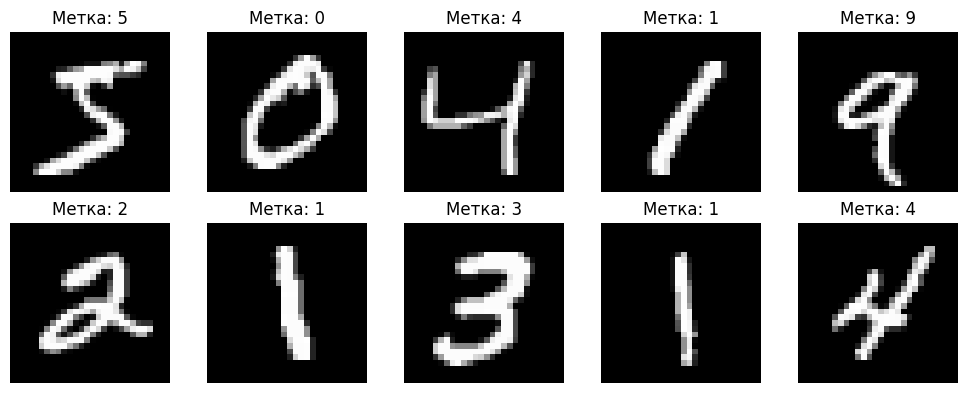

Эпоха  1/20 | Ошибка классификации (train): 0.0999 | Время: 2.34с
Эпоха  2/20 | Ошибка классификации (train): 0.0539 | Время: 2.32с
Эпоха  3/20 | Ошибка классификации (train): 0.0397 | Время: 2.34с
Эпоха  4/20 | Ошибка классификации (train): 0.0315 | Время: 2.02с
Эпоха  5/20 | Ошибка классификации (train): 0.0263 | Время: 1.68с
Эпоха  6/20 | Ошибка классификации (train): 0.0221 | Время: 2.31с
Эпоха  7/20 | Ошибка классификации (train): 0.0182 | Время: 2.30с
Эпоха  8/20 | Ошибка классификации (train): 0.0161 | Время: 2.24с
Эпоха  9/20 | Ошибка классификации (train): 0.0142 | Время: 1.65с
Эпоха 10/20 | Ошибка классификации (train): 0.0126 | Время: 1.77с
Эпоха 11/20 | Ошибка классификации (train): 0.0110 | Время: 1.65с
Эпоха 12/20 | Ошибка классификации (train): 0.0098 | Время: 1.66с
Эпоха 13/20 | Ошибка классификации (train): 0.0083 | Время: 1.77с
Эпоха 14/20 | Ошибка классификации (train): 0.0078 | Время: 1.67с
Эпоха 15/20 | Ошибка классификации (train): 0.0064 | Время: 2.26с
Эпоха 16/2

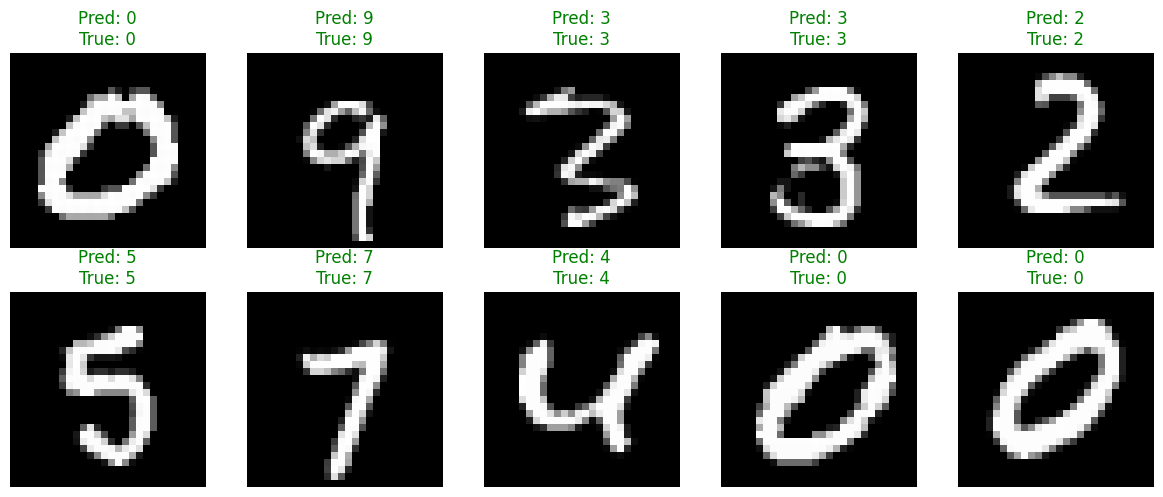

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time
import struct
import os

from sklearn.datasets import fetch_openml

def load_mnist_easiest():
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype('float32') / 255.0
    y = mnist.target.astype('int')
    
    X_train, X_test = X[:60000], X[60000:]
    y_train, y_test = y[:60000], y[60000:]
    
    return X_train, X_test, y_train, y_test

print("\nДемонстрация избранных изображений и меток классов для подтверждения корректности загрузки:")
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten() 

for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Метка: {y_train[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

def initialize_parameters():
    np.random.seed(42)
    
    input_size = 784
    hidden_size = 300
    output_size = 10
    
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
    b2 = np.zeros((1, output_size))
    
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

parameters = initialize_parameters()

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def forward(X, params):
    W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]
    
    Z1 = np.dot(X, W1) + b1      
    A1 = relu(Z1)               
    Z2 = np.dot(A1, W2) + b2    
    A2 = softmax(Z2)             
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

def compute_loss(y_pred, y_true):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
    return loss

def one_hot_encode(y, num_classes=10):
    y_encoded = np.zeros((y.size, num_classes))
    y_encoded[np.arange(y.size), y] = 1
    return y_encoded

def backward(X, y_true, params, cache):
    m = X.shape[0]
    W1, W2 = params["W1"], params["W2"]
    A1, A2, Z1 = cache["A1"], cache["A2"], cache["Z1"]

    dZ2 = A2 - y_true  
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)  
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

def update_parameters(params, grads, learning_rate):
    for key in params:
        params[key] -= learning_rate * grads["d" + key]
    return params

def train_network(X_train, y_train, X_test, y_test, parameters, 
                 epochs=20, batch_size=64, learning_rate=0.1):
    
    y_train_oh = one_hot_encode(y_train)
    n_train = X_train.shape[0]
    
    for epoch in range(epochs):
        start_time = time.time()
        
        indices = np.random.permutation(n_train)
        X_shuffled = X_train[indices]
        y_shuffled_oh = y_train_oh[indices]
        y_shuffled = y_train[indices]
        
        epoch_loss = 0
        epoch_correct = 0
        
        for i in range(0, n_train, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch_oh = y_shuffled_oh[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            y_pred, cache = forward(X_batch, parameters)
            
            loss = compute_loss(y_pred, y_batch_oh)
            epoch_loss += loss
            predictions = np.argmax(y_pred, axis=1)
            epoch_correct += np.sum(predictions == y_batch)
  
            grads = backward(X_batch, y_batch_oh, parameters, cache)
            parameters = update_parameters(parameters, grads, learning_rate)
        
        train_accuracy = epoch_correct / n_train
        train_classification_error = 1 - train_accuracy
        
        test_predictions, _ = forward(X_test, parameters)
        test_classification_error = compute_classification_error(test_predictions, y_test)
        
        epoch_time = time.time() - start_time
        
        print(f"Эпоха {epoch+1:2d}/{epochs} | "
              f"Ошибка классификации (train): {train_classification_error:.4f} | "
              f"Время: {epoch_time:.2f}с")
    
    return parameters


trained_params = train_network(
    X_train, y_train, X_test, y_test,
    parameters,
    epochs=20,
    batch_size=64,
    learning_rate=0.1
)

print("Результаты:")

test_predictions, _ = forward(X_test, trained_params)
final_test_error = compute_classification_error(test_predictions, y_test)
final_accuracy = 1 - final_test_error

print(f"Ошибка классификации на тестовом наборе: {final_test_error:.4f}")
print(f"Точность на тестовом наборе: {final_accuracy*100:.2f}%")


print("\nДемонстрация предсказаний на тестовых данных:")

indices = np.random.choice(len(X_test), 10, replace=False)
X_samples = X_test[indices]
y_true = y_test[indices]

predictions, _ = forward(X_samples, trained_params)
y_pred = np.argmax(predictions, axis=1)

# Визуализация
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(samples[i].reshape(28, 28), cmap='gray')
    is_correct = pred_labels[i] == true_labels[i]
    color = 'green' if is_correct else 'red'
    ax.set_title(f'Pred: {pred_labels[i]}\nTrue: {true_labels[i]}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

